# Big Data Clustering Project: K-means Comparison


## Apache Spark vs Scikit-Learn

### PART 1: SETUP AND IMPORTS


In [32]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
import psutil
import warnings
warnings.filterwarnings('ignore')

# PySpark imports
import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-17-openjdk-amd64'
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans as SparkKMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler as SparkScaler
from pyspark.ml.evaluation import ClusteringEvaluator

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


### PART 2: INITIALIZE SPARK SESSION

In [33]:
spark = SparkSession.builder \
    .appName("KMeansComparison") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "4") \
    .getOrCreate()

print(f"✓ Spark Session created: {spark.version}")

✓ Spark Session created: 3.5.1


### PART 3: DATA GENERATION AND PREPARATION


In [34]:
def load_datasets(sample_large=110000):
    datasets = {}

    # 1) Small dataset: Wine Quality (UCI) - features only
    try:
        wine_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
        wine_df = pd.read_csv(wine_url, sep=';')
        # Drop the target column 'quality' and use features only
        if 'quality' in wine_df.columns:
            X_wine = wine_df.drop(columns=['quality']).values
        else:
            X_wine = wine_df.values
        datasets['small'] = (X_wine, 'Wine Quality (Small)')
        print(f"✓ Loaded Wine Quality: {X_wine.shape[0]:,} samples, {X_wine.shape[1]} features")
    except Exception as e:
        print(f"⚠ Could not load Wine dataset: {e}")
        datasets['small'] = (None, 'Wine Quality (Small) - failed to load')

    # 2) Medium dataset: MNIST
    try:
        from sklearn.datasets import fetch_openml
        print("Downloading MNIST (may take a minute)...")
        mnist = fetch_openml('mnist_784', version=1, as_frame=False)
        X_mnist = mnist.data.astype(np.float32)
        datasets['medium'] = (X_mnist, 'MNIST (Medium)')
        print(f"✓ Loaded MNIST: {X_mnist.shape[0]:,} samples, {X_mnist.shape[1]} features")
    except Exception as e:
        print(f"⚠ Could not fetch MNIST via openml: {e}. Falling back to sklearn digits dataset.")
        try:
            from sklearn.datasets import load_digits
            digits = load_digits()
            X_digits = digits.data.astype(np.float32)
            datasets['medium'] = (X_digits, 'Digits (Fallback medium)')
            print(f"✓ Loaded Digits fallback: {X_digits.shape[0]:,} samples, {X_digits.shape[1]} features")
        except Exception as e2:
            print(f"⚠ Could not load fallback digits dataset: {e2}")
            datasets['medium'] = (None, 'MNIST (Medium) - failed to load')

    # 3) Large dataset: Synthetic data
    try:
        print("Generating synthetic large dataset...")
        X_synthetic, _ = make_blobs(n_samples=sample_large,
                                     n_features=50,
                                     centers=10,
                                     random_state=42,
                                     cluster_std=0.8)
        X_synthetic = X_synthetic.astype(np.float32)
        datasets['large'] = (X_synthetic, f'Synthetic (Large - {len(X_synthetic):,} samples, 50 features)')
        print(f"✓ Generated Synthetic dataset: {len(X_synthetic):,} samples, {X_synthetic.shape[1]} features")
    except Exception as e:
        print(f"⚠ Could not generate synthetic dataset: {e}")
        datasets['large'] = (None, 'Synthetic (Large) - failed to generate')

    return datasets

print("Loading datasets (Wine, MNIST, Synthetic )...")
datasets = load_datasets(sample_large=110000) # adjust sample_large as needed (set None to attempt full download)
print(f"✓ Prepared datasets dictionary with {len(datasets)} entries")


Loading datasets (Wine, MNIST, Synthetic )...
✓ Loaded Wine Quality: 1,599 samples, 11 features
✓ Loaded MNIST: 70,000 samples, 784 features
Generating synthetic large dataset...
✓ Generated Synthetic dataset: 110,000 samples, 50 features
✓ Prepared datasets dictionary with 3 entries


### PART 4: SCIKIT-LEARN IMPLEMENTATION

In [35]:
def run_sklearn_kmeans(X, n_clusters=5, verbose=True):
    if verbose:
        print(f"\n--- Scikit-Learn K-means (n={len(X):,}) ---")

    # Standardize data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Track resource usage
    start_time = time.time()
    process = psutil.Process()
    mem_before = process.memory_info().rss / 1024 / 1024  # MB
    cpu_before = psutil.cpu_percent(interval=0.1)

    # Run K-means
    kmeans = KMeans(n_clusters=n_clusters,
                   init='k-means++',
                   max_iter=300,
                   n_init=10,
                   random_state=42,
                   verbose=0)

    labels = kmeans.fit_predict(X_scaled)

    # Calculate metrics
    execution_time = time.time() - start_time
    mem_after = process.memory_info().rss / 1024 / 1024
    cpu_after = psutil.cpu_percent(interval=0.1)

    inertia = kmeans.inertia_
    silhouette = silhouette_score(X_scaled, labels, sample_size=min(10000, len(X)))
    db_score = davies_bouldin_score(X_scaled, labels)

    results = {
        'execution_time': execution_time,
        'memory_mb': mem_after - mem_before,
        'cpu_percent': (cpu_before + cpu_after) / 2,
        'inertia': inertia,
        'silhouette': silhouette,
        'davies_bouldin': db_score,
        'labels': labels,
        'centers': kmeans.cluster_centers_,
        'n_iter': kmeans.n_iter_
    }

    if verbose:
        print(f"Execution Time: {execution_time:.2f}s")
        print(f"Memory Used: {results['memory_mb']:.1f} MB")
        print(f"CPU Usage: {results['cpu_percent']:.1f}%")
        print(f"Iterations: {results['n_iter']}")
        print(f"Inertia: {inertia:.2f}")
        print(f"Silhouette Score: {silhouette:.3f}")
        print(f"Davies-Bouldin Score: {db_score:.3f}")

    return results

### PART 5: PYSPARK IMPLEMENTATION

In [36]:
def run_spark_kmeans(spark, X, n_clusters=5, verbose=True):
    """
    Run K-means using PySpark and collect metrics

    Args:
        spark: The SparkSession object
        X: Data array
        n_clusters: Number of clusters
        verbose: Print progress

    Returns:
        Dictionary with results
    """
    if verbose:
        print(f"\n--- PySpark K-means (n={len(X):,}) ---")

    # Convert to DataFrame with column names
    columns = [f'feature_{i}' for i in range(X.shape[1])]
    df_pandas = pd.DataFrame(X, columns=columns)
    df = spark.createDataFrame(df_pandas)

    # Assemble features into vector column
    assembler = VectorAssembler(inputCols=columns, outputCol='features_vec')
    df = assembler.transform(df)

    # Standardize features
    scaler = SparkScaler(inputCol='features_vec', outputCol='features',
                        withStd=True, withMean=True)
    scaler_model = scaler.fit(df)
    df_scaled = scaler_model.transform(df)

    # Track resource usage
    start_time = time.time()
    process = psutil.Process()
    mem_before = process.memory_info().rss / 1024 / 1024
    cpu_before = psutil.cpu_percent(interval=0.1)

    # Run K-means
    kmeans = SparkKMeans(k=n_clusters, seed=42, maxIter=300,
                        initMode='k-means||',  # Spark's parallel k-means++
                        featuresCol='features')

    model = kmeans.fit(df_scaled)
    predictions = model.transform(df_scaled)

    # Calculate metrics
    execution_time = time.time() - start_time
    mem_after = process.memory_info().rss / 1024 / 1024
    cpu_after = psutil.cpu_percent(interval=0.1)

    # Get predictions as numpy array
    labels = np.array(predictions.select('prediction').collect()).flatten()

    # Silhouette score (using evaluator)
    evaluator = ClusteringEvaluator(featuresCol='features',
                                   predictionCol='prediction',
                                   metricName='silhouette')
    silhouette = evaluator.evaluate(predictions)

    # Inertia approximation (Spark calls it "computeCost")
    inertia = model.summary.trainingCost

    results = {
        'execution_time': execution_time,
        'memory_mb': mem_after - mem_before,
        'cpu_percent': (cpu_before + cpu_after) / 2,
        'inertia': inertia,
        'silhouette': silhouette,
        'labels': labels,
        'centers': model.clusterCenters()
    }

    if verbose:
        print(f"Execution Time: {execution_time:.2f}s")
        print(f"Memory Used: {results['memory_mb']:.1f} MB")
        print(f"CPU Usage: {results['cpu_percent']:.1f}%")
        print(f"Inertia: {inertia:.2f}")
        print(f"Silhouette Score: {silhouette:.3f}")

    return results

### PART 6: RUN EXPERIMENTS

In [37]:
print("\n" + "="*70)
print("RUNNING COMPARATIVE EXPERIMENTS")
print("="*70)

results_comparison = {
    'sklearn': {},
    'spark': {}
}

# Run experiments on all dataset sizes
for size_name, (X, description) in datasets.items():
    print(f"\n{'='*70}")
    print(f"Testing on: {description}")
    print(f"{'='*70}")

    # Run scikit-learn
    sklearn_results = run_sklearn_kmeans(X, n_clusters=5)
    results_comparison['sklearn'][size_name] = sklearn_results

    # Run PySpark
    spark_results = run_spark_kmeans(spark, X, n_clusters=5)
    results_comparison['spark'][size_name] = spark_results

    # Quick comparison
    print(f"\n📊 Quick Comparison for {description}:")
    print(f"Speedup: {sklearn_results['execution_time']/spark_results['execution_time']:.2f}x " +
          f"({'Spark' if spark_results['execution_time'] < sklearn_results['execution_time'] else 'sklearn'} faster)")


RUNNING COMPARATIVE EXPERIMENTS

Testing on: Wine Quality (Small)

--- Scikit-Learn K-means (n=1,599) ---
Execution Time: 0.15s
Memory Used: 0.0 MB
CPU Usage: 7.2%
Iterations: 13
Inertia: 10155.51
Silhouette Score: 0.190
Davies-Bouldin Score: 1.463

--- PySpark K-means (n=1,599) ---
Execution Time: 2.88s
Memory Used: 0.0 MB
CPU Usage: 7.5%
Inertia: 10149.16
Silhouette Score: 0.301

📊 Quick Comparison for Wine Quality (Small):
Speedup: 0.05x (sklearn faster)

Testing on: MNIST (Medium)

--- Scikit-Learn K-means (n=70,000) ---
Execution Time: 61.82s
Memory Used: -1.1 MB
CPU Usage: 40.9%
Iterations: 46
Inertia: 45381344.00
Silhouette Score: 0.034
Davies-Bouldin Score: 3.671

--- PySpark K-means (n=70,000) ---
Execution Time: 314.66s
Memory Used: 0.0 MB
CPU Usage: 13.2%
Inertia: 45383810.42
Silhouette Score: -0.031

📊 Quick Comparison for MNIST (Medium):
Speedup: 0.20x (sklearn faster)

Testing on: Synthetic (Large - 110,000 samples, 50 features)

--- Scikit-Learn K-means (n=110,000) ---


### PART 7: K-VARIATION EXPERIMENTS

In [38]:
print("\n" + "="*70)
print("K-VARIATION EXPERIMENTS: Testing K values [2,3,5,10]")
print("="*70)

k_values = [2,3,5,10]
results_k_variation = {}

for size_name, (X, description) in datasets.items():
    print(f"\n{'-'*60}\nDataset: {description} ({size_name})\n{'-'*60}")
    if X is None:
        print(f"⚠ Skipping {size_name}; data not available.")
        continue

    results_k_variation[size_name] = {'k': [], 'sklearn': {'execution_time': [], 'memory_mb': [], 'inertia': [], 'silhouette': []}, 'spark': {'execution_time': [], 'memory_mb': [], 'inertia': [], 'silhouette': []}}

    for k in k_values:
        print(f"K={k}:", end=" ")
        results_k_variation[size_name]['k'].append(k)
        # sklearn
        try:
            res_sk = run_sklearn_kmeans(X, n_clusters=k, verbose=False)
            results_k_variation[size_name]['sklearn']['execution_time'].append(res_sk.get('execution_time'))
            results_k_variation[size_name]['sklearn']['memory_mb'].append(res_sk.get('memory_mb'))
            results_k_variation[size_name]['sklearn']['inertia'].append(res_sk.get('inertia'))
            results_k_variation[size_name]['sklearn']['silhouette'].append(res_sk.get('silhouette'))
            print("sklearn✓", end=" ")
        except Exception as e:
            print(f"sklearn failed ({e})", end=" ")
            for key in ['execution_time','memory_mb','inertia','silhouette']:
                results_k_variation[size_name]['sklearn'][key].append(None)

        # spark
        try:
            res_sp = run_spark_kmeans(spark, X, n_clusters=k, verbose=False)
            results_k_variation[size_name]['spark']['execution_time'].append(res_sp.get('execution_time'))
            results_k_variation[size_name]['spark']['memory_mb'].append(res_sp.get('memory_mb'))
            results_k_variation[size_name]['spark']['inertia'].append(res_sp.get('inertia'))
            results_k_variation[size_name]['spark']['silhouette'].append(res_sp.get('silhouette'))
            print("spark✓")
        except Exception as e:
            print(f"spark failed ({e})")
            for key in ['execution_time','memory_mb','inertia','silhouette']:
                results_k_variation[size_name]['spark'][key].append(None)

    print(f"Completed K-variation for {size_name}.")

print("\n✓ K-variation experiments complete. Results in `results_k_variation`." )


K-VARIATION EXPERIMENTS: Testing K values [2,3,5,10]

------------------------------------------------------------
Dataset: Wine Quality (Small) (small)
------------------------------------------------------------
K=2: sklearn✓ spark✓
K=3: sklearn✓ spark✓
K=5: sklearn✓ spark✓
K=10: sklearn✓ spark✓
Completed K-variation for small.

------------------------------------------------------------
Dataset: MNIST (Medium) (medium)
------------------------------------------------------------
K=2: sklearn✓ spark✓
K=3: sklearn✓ spark✓
K=5: sklearn✓ spark✓
K=10: sklearn✓ spark✓
Completed K-variation for medium.

------------------------------------------------------------
Dataset: Synthetic (Large - 110,000 samples, 50 features) (large)
------------------------------------------------------------
K=2: sklearn✓ spark✓
K=3: sklearn✓ spark✓
K=5: sklearn✓ spark✓
K=10: sklearn✓ spark✓
Completed K-variation for large.

✓ K-variation experiments complete. Results in `results_k_variation`.


In [42]:
import pickle

#Save the results to a file on the Colab disk
with open('kmeans_results_backup.pkl', 'wb') as f:
    pickle.dump(results_k_variation, f)

print("Results saved to 'kmeans_results_backup.pkl'.")

Results saved to 'kmeans_results_backup.pkl'.


### PART 8 : COMPREHENSIVE VISUALIZATION

In [43]:
print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)
colors = {'sklearn': '#1f77b4', 'spark': '#ff7f0e'}
dataset_colors = {'small': '#2ecc71', 'medium': '#3498db', 'large': '#e74c3c'}


GENERATING VISUALIZATIONS


#### 8.1 EXECUTION TIME COMPARISON BY K

✓ Saved: images/01_execution_time_vs_k.png


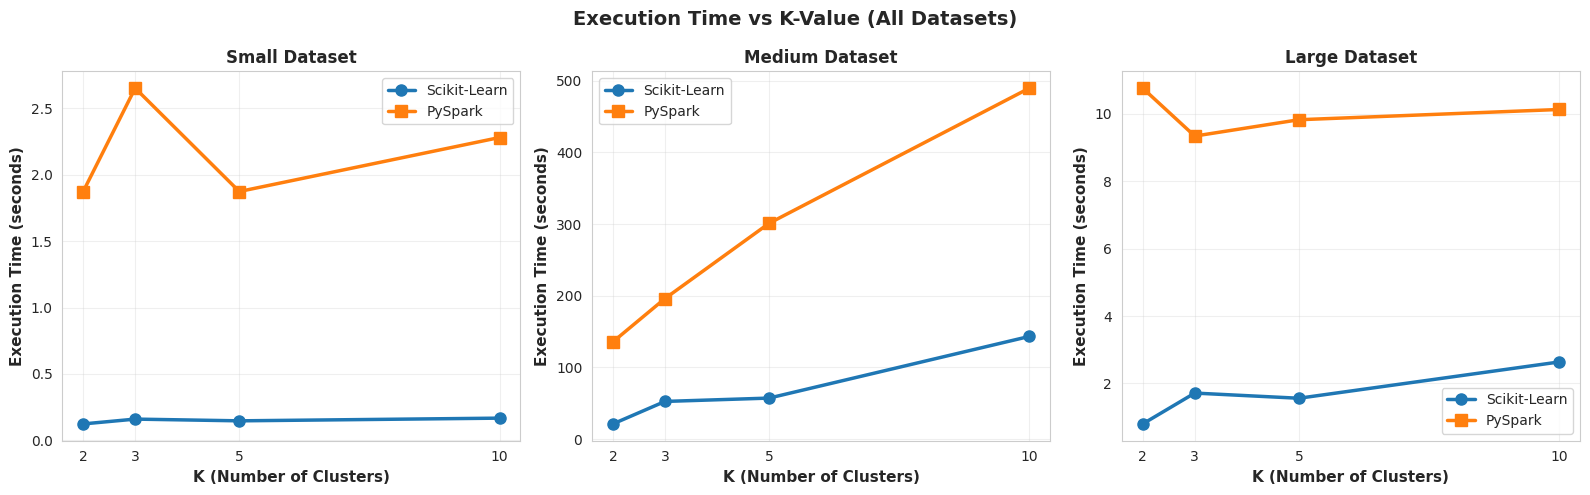

In [44]:

fig1, axes = plt.subplots(1, 3, figsize=(16, 5))
fig1.suptitle('Execution Time vs K-Value (All Datasets)', fontsize=14, fontweight='bold')

for idx, (size_name, description) in enumerate([('small', 'Small Dataset'),
                                                  ('medium', 'Medium Dataset'),
                                                  ('large', 'Large Dataset')]):
    if size_name not in results_k_variation:
        continue

    data = results_k_variation[size_name]
    k_vals = data['k']
    sk_times = data['sklearn']['execution_time']
    sp_times = data['spark']['execution_time']

    ax = axes[idx]
    ax.plot(k_vals, sk_times, marker='o', linewidth=2.5, markersize=8,
            label='Scikit-Learn', color=colors['sklearn'])
    ax.plot(k_vals, sp_times, marker='s', linewidth=2.5, markersize=8,
            label='PySpark', color=colors['spark'])

    ax.set_xlabel('K (Number of Clusters)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Execution Time (seconds)', fontsize=11, fontweight='bold')
    ax.set_title(description, fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(k_vals)

plt.tight_layout()
plt.savefig('images/01_execution_time_vs_k.png', dpi=300, bbox_inches='tight')
print("✓ Saved: images/01_execution_time_vs_k.png")
plt.show()

#### 8.2 SILHOUETTE SCORE COMPARISON BY K

✓ Saved: images/02_silhouette_vs_k.png


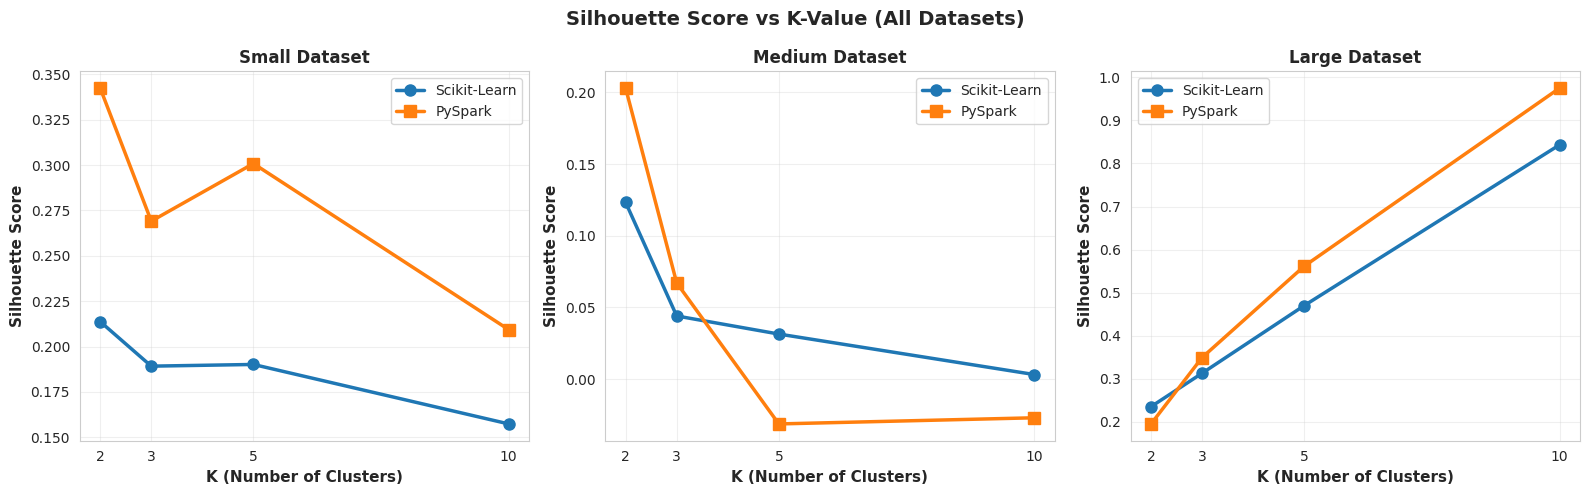

In [45]:
fig2, axes = plt.subplots(1, 3, figsize=(16, 5))
fig2.suptitle('Silhouette Score vs K-Value (All Datasets)', fontsize=14, fontweight='bold')

for idx, (size_name, description) in enumerate([('small', 'Small Dataset'),
                                                  ('medium', 'Medium Dataset'),
                                                  ('large', 'Large Dataset')]):
    if size_name not in results_k_variation:
        continue

    data = results_k_variation[size_name]
    k_vals = data['k']
    sk_sil = data['sklearn']['silhouette']
    sp_sil = data['spark']['silhouette']

    ax = axes[idx]
    ax.plot(k_vals, sk_sil, marker='o', linewidth=2.5, markersize=8,
            label='Scikit-Learn', color=colors['sklearn'])
    ax.plot(k_vals, sp_sil, marker='s', linewidth=2.5, markersize=8,
            label='PySpark', color=colors['spark'])

    ax.set_xlabel('K (Number of Clusters)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Silhouette Score', fontsize=11, fontweight='bold')
    ax.set_title(description, fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(k_vals)

plt.tight_layout()
plt.savefig('images/02_silhouette_vs_k.png', dpi=300, bbox_inches='tight')
print("✓ Saved: images/02_silhouette_vs_k.png")
plt.show()

#### 8.1 INERTIA COMPARISON BY K



✓ Saved: images/03_inertia_vs_k.png


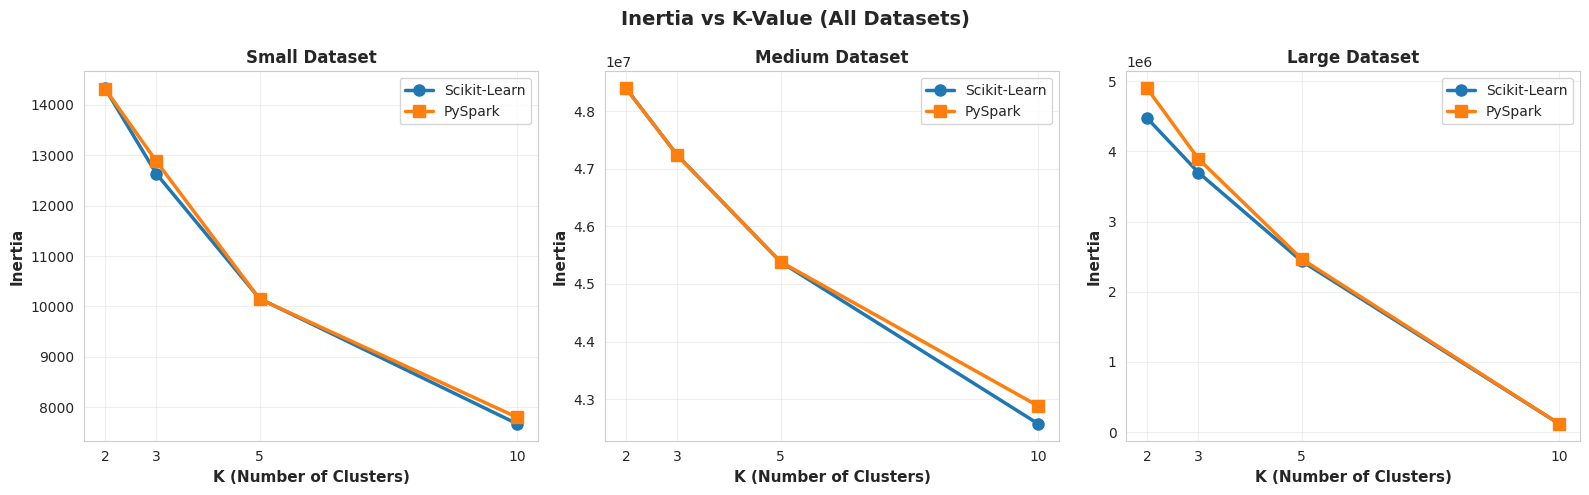

In [46]:
fig3, axes = plt.subplots(1, 3, figsize=(16, 5))
fig3.suptitle('Inertia vs K-Value (All Datasets)', fontsize=14, fontweight='bold')

for idx, (size_name, description) in enumerate([('small', 'Small Dataset'),
                                                  ('medium', 'Medium Dataset'),
                                                  ('large', 'Large Dataset')]):
    if size_name not in results_k_variation:
        continue

    data = results_k_variation[size_name]
    k_vals = data['k']
    sk_inertia = data['sklearn']['inertia']
    sp_inertia = data['spark']['inertia']

    ax = axes[idx]
    ax.plot(k_vals, sk_inertia, marker='o', linewidth=2.5, markersize=8,
            label='Scikit-Learn', color=colors['sklearn'])
    ax.plot(k_vals, sp_inertia, marker='s', linewidth=2.5, markersize=8,
            label='PySpark', color=colors['spark'])

    ax.set_xlabel('K (Number of Clusters)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Inertia', fontsize=11, fontweight='bold')
    ax.set_title(description, fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(k_vals)

plt.tight_layout()
plt.savefig('images/03_inertia_vs_k.png', dpi=300, bbox_inches='tight')
print("✓ Saved: images/03_inertia_vs_k.png")
plt.show()

#### 8.4 MEMORY USAGE COMPARISON BY K

✓ Saved: images/04_memory_vs_k.png


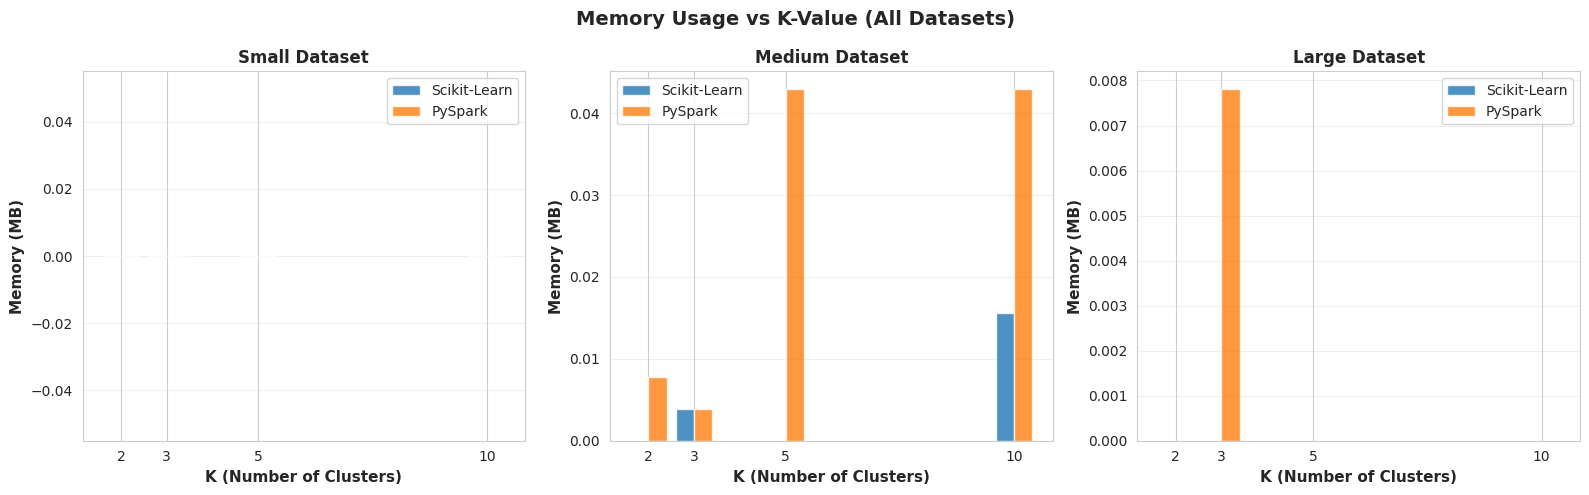

In [47]:
fig4, axes = plt.subplots(1, 3, figsize=(16, 5))
fig4.suptitle('Memory Usage vs K-Value (All Datasets)', fontsize=14, fontweight='bold')

for idx, (size_name, description) in enumerate([('small', 'Small Dataset'),
                                                  ('medium', 'Medium Dataset'),
                                                  ('large', 'Large Dataset')]):
    if size_name not in results_k_variation:
        continue

    data = results_k_variation[size_name]
    k_vals = data['k']
    sk_mem = data['sklearn']['memory_mb']
    sp_mem = data['spark']['memory_mb']

    ax = axes[idx]
    ax.bar(np.array(k_vals) - 0.2, sk_mem, width=0.4, label='Scikit-Learn',
           color=colors['sklearn'], alpha=0.8)
    ax.bar(np.array(k_vals) + 0.2, sp_mem, width=0.4, label='PySpark',
           color=colors['spark'], alpha=0.8)

    ax.set_xlabel('K (Number of Clusters)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Memory (MB)', fontsize=11, fontweight='bold')
    ax.set_title(description, fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_xticks(k_vals)

plt.tight_layout()
plt.savefig('images/04_memory_vs_k.png', dpi=300, bbox_inches='tight')
print("✓ Saved: images/04_memory_vs_k.png")
plt.show()

#### 8.5 EXECUTION TIME: SKLEARN ACROSS DATASETS

✓ Saved: images/05_sklearn_time_across_datasets.png


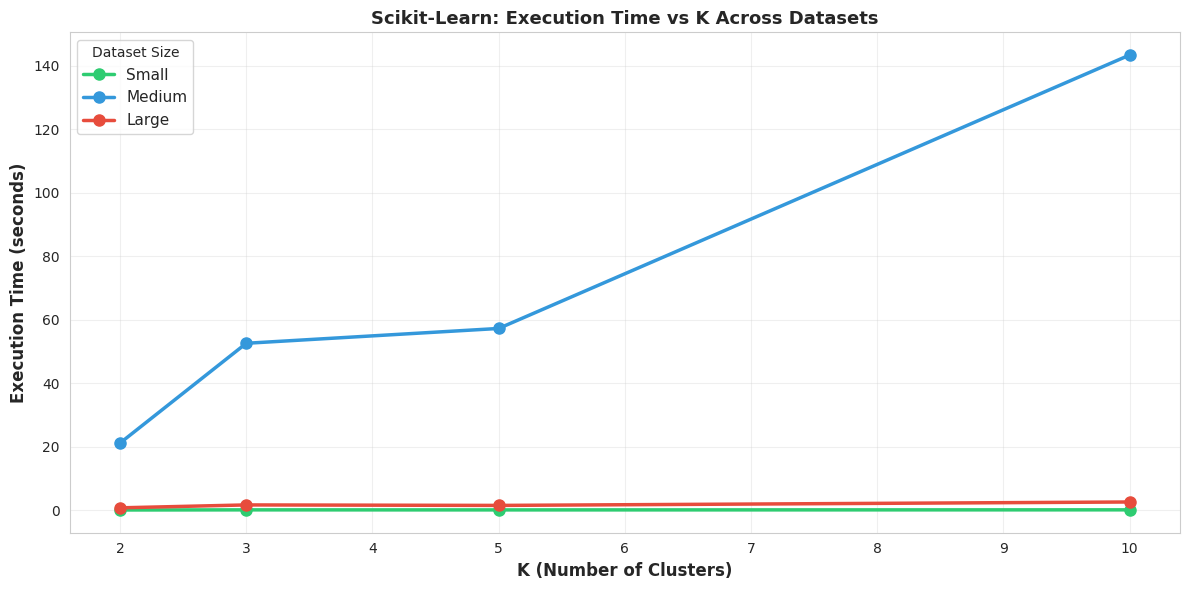

In [48]:
fig5, ax = plt.subplots(figsize=(12, 6))

for size_name in ['small', 'medium', 'large']:
    if size_name not in results_k_variation:
        continue
    data = results_k_variation[size_name]
    k_vals = data['k']
    sk_times = data['sklearn']['execution_time']
    ax.plot(k_vals, sk_times, marker='o', linewidth=2.5, markersize=8,
            label=size_name.capitalize(), color=dataset_colors[size_name])

ax.set_xlabel('K (Number of Clusters)', fontsize=12, fontweight='bold')
ax.set_ylabel('Execution Time (seconds)', fontsize=12, fontweight='bold')
ax.set_title('Scikit-Learn: Execution Time vs K Across Datasets', fontsize=13, fontweight='bold')
ax.legend(fontsize=11, title='Dataset Size')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/05_sklearn_time_across_datasets.png', dpi=300, bbox_inches='tight')
print("✓ Saved: images/05_sklearn_time_across_datasets.png")
plt.show()

#### 8.6 EXECUTION TIME: PYSPARK ACROSS DATASETS

✓ Saved: images/06_pyspark_time_across_datasets.png


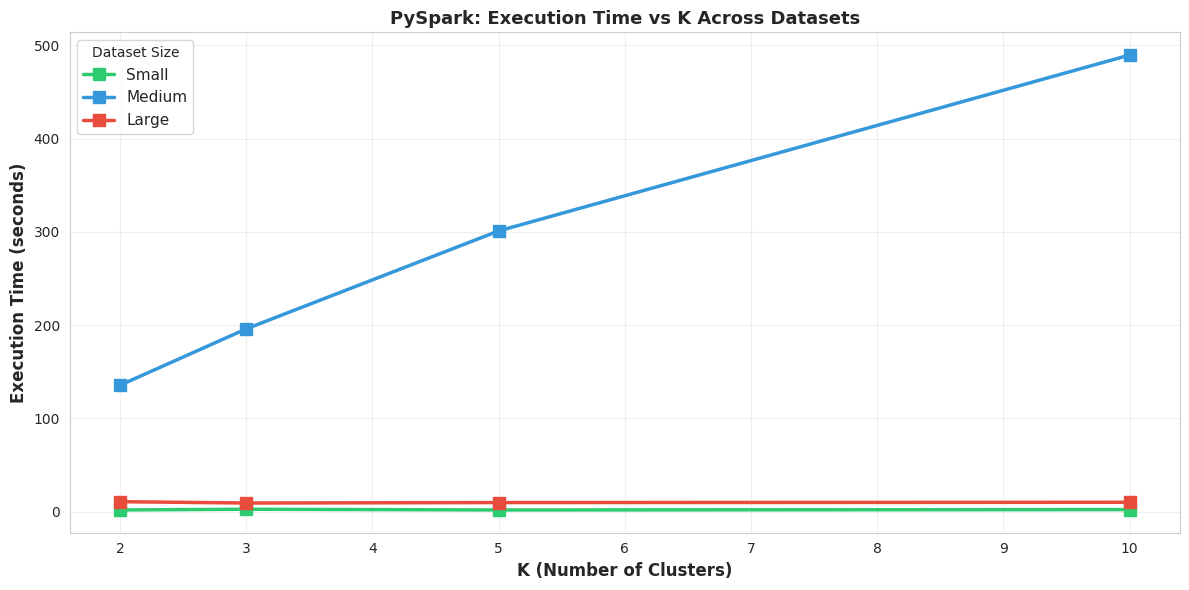

In [49]:
fig6, ax = plt.subplots(figsize=(12, 6))

for size_name in ['small', 'medium', 'large']:
    if size_name not in results_k_variation:
        continue
    data = results_k_variation[size_name]
    k_vals = data['k']
    sp_times = data['spark']['execution_time']
    ax.plot(k_vals, sp_times, marker='s', linewidth=2.5, markersize=8,
            label=size_name.capitalize(), color=dataset_colors[size_name])

ax.set_xlabel('K (Number of Clusters)', fontsize=12, fontweight='bold')
ax.set_ylabel('Execution Time (seconds)', fontsize=12, fontweight='bold')
ax.set_title('PySpark: Execution Time vs K Across Datasets', fontsize=13, fontweight='bold')
ax.legend(fontsize=11, title='Dataset Size')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/06_pyspark_time_across_datasets.png', dpi=300, bbox_inches='tight')
print("✓ Saved: images/06_pyspark_time_across_datasets.png")
plt.show()

#### 8.7 SPEEDUP FACTOR: SKLEARN vs SPARK

✓ Saved: images/07_speedup_factor.png


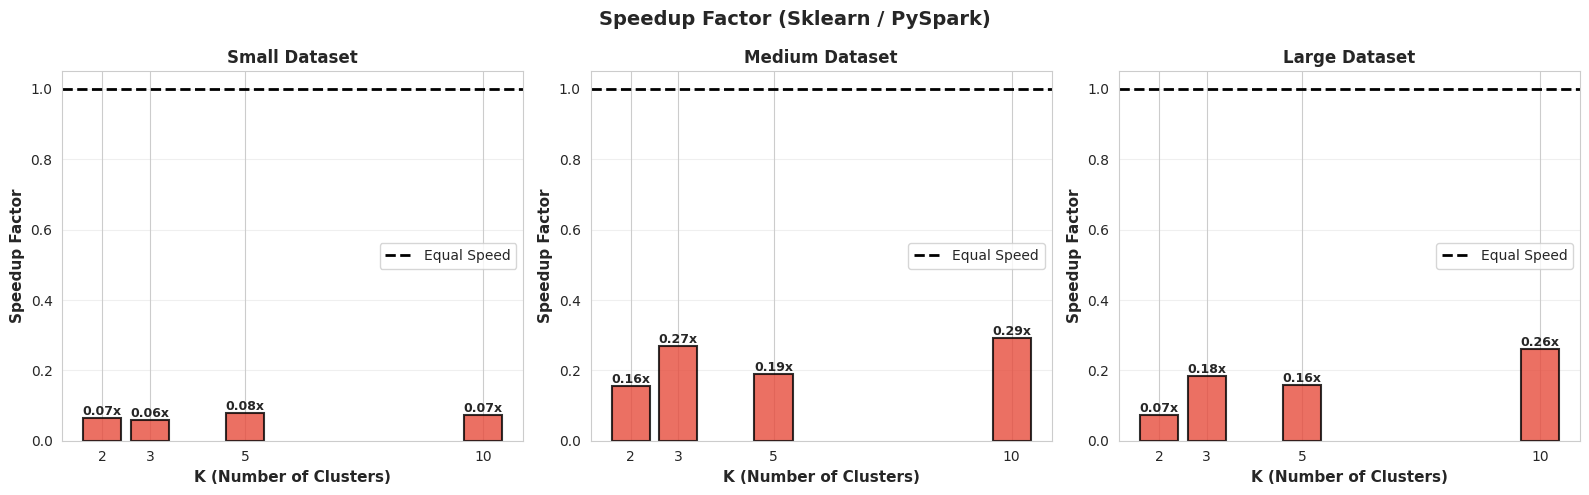

In [50]:
fig7, axes = plt.subplots(1, 3, figsize=(16, 5))
fig7.suptitle('Speedup Factor (Sklearn / PySpark)', fontsize=14, fontweight='bold')

for idx, (size_name, description) in enumerate([('small', 'Small Dataset'),
                                                  ('medium', 'Medium Dataset'),
                                                  ('large', 'Large Dataset')]):
    if size_name not in results_k_variation:
        continue

    data = results_k_variation[size_name]
    k_vals = data['k']
    sk_times = data['sklearn']['execution_time']
    sp_times = data['spark']['execution_time']

    speedup = [sk / sp if sp and sk else 1 for sk, sp in zip(sk_times, sp_times)]

    ax = axes[idx]
    bars = ax.bar(k_vals, speedup, color=['#2ecc71' if s > 1 else '#e74c3c' for s in speedup],
                  alpha=0.8, edgecolor='black', linewidth=1.5)
    ax.axhline(y=1, color='black', linestyle='--', linewidth=2, label='Equal Speed')

    ax.set_xlabel('K (Number of Clusters)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Speedup Factor', fontsize=11, fontweight='bold')
    ax.set_title(description, fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_xticks(k_vals)

    # Add value labels on bars
    for bar, val in zip(bars, speedup):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2f}x', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('images/07_speedup_factor.png', dpi=300, bbox_inches='tight')
print("✓ Saved: images/07_speedup_factor.png")
plt.show()

#### 8.8 COMPREHENSIVE HEATMAP

✓ Saved: images/08_metric_heatmaps.png


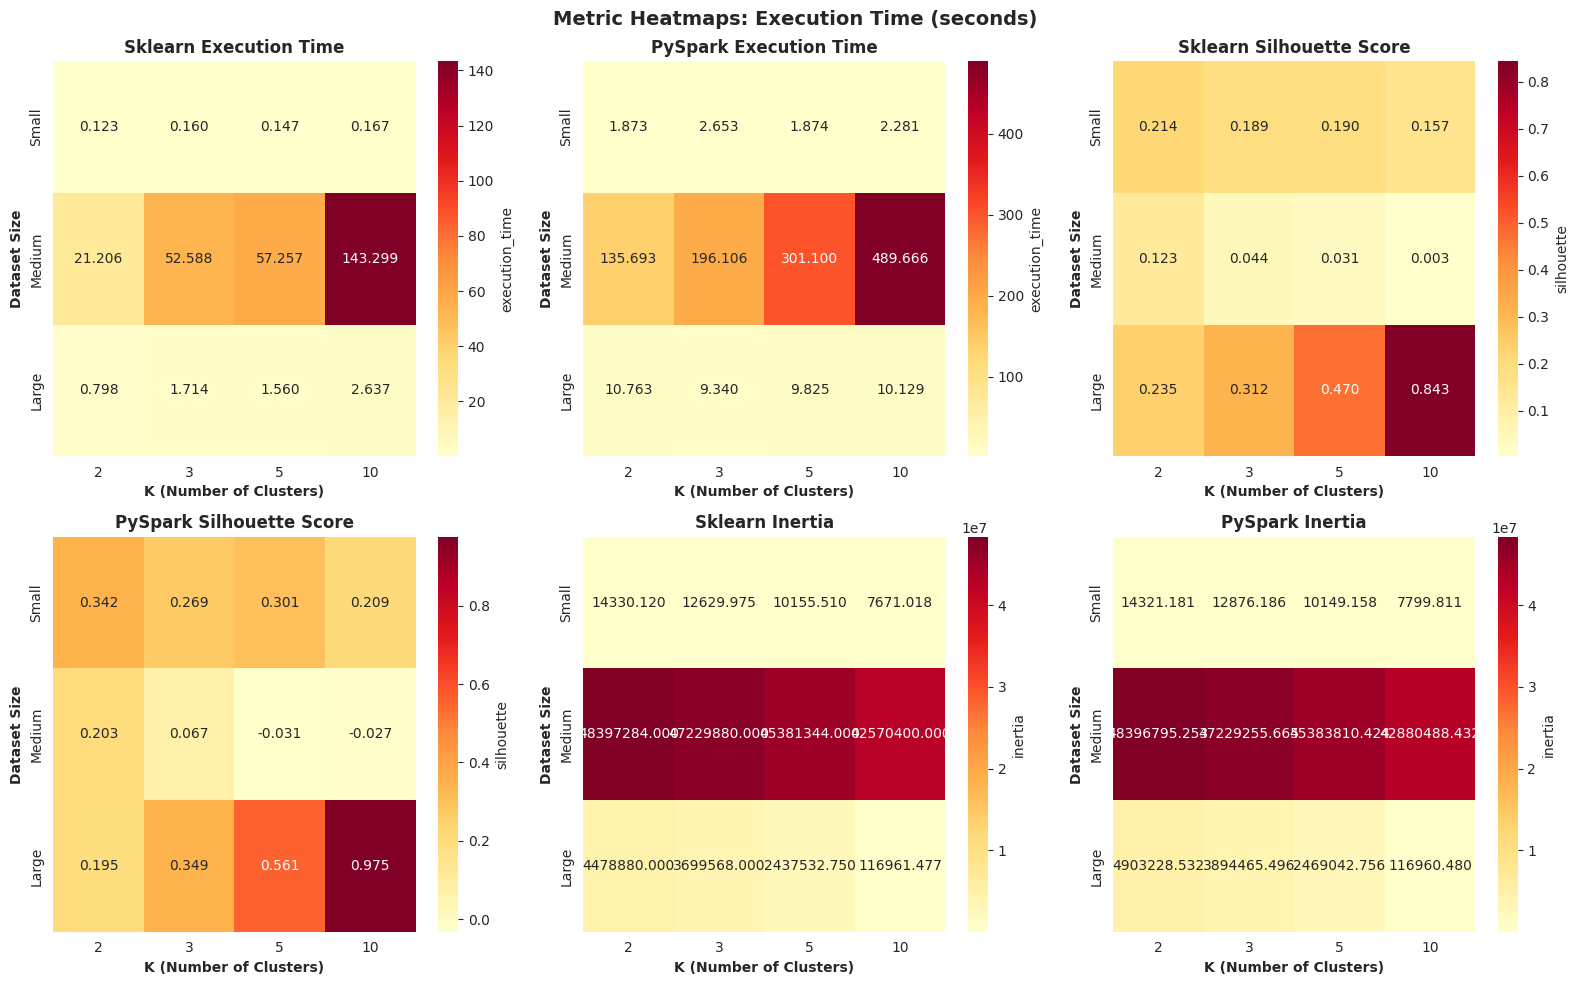

In [51]:
fig8, axes = plt.subplots(2, 3, figsize=(16, 10))
fig8.suptitle('Metric Heatmaps: Execution Time (seconds)', fontsize=14, fontweight='bold')

metrics_to_plot = [
    ('sklearn', 'execution_time', 'Sklearn Execution Time'),
    ('spark', 'execution_time', 'PySpark Execution Time'),
    ('sklearn', 'silhouette', 'Sklearn Silhouette Score'),
    ('spark', 'silhouette', 'PySpark Silhouette Score'),
    ('sklearn', 'inertia', 'Sklearn Inertia'),
    ('spark', 'inertia', 'PySpark Inertia')
]

for plot_idx, (framework, metric, title) in enumerate(metrics_to_plot):
    row, col = plot_idx // 3, plot_idx % 3
    ax = axes[row, col]

    # Build data matrix
    data_matrix = []
    size_labels = []

    for size_name in ['small', 'medium', 'large']:
        if size_name not in results_k_variation:
            continue
        data = results_k_variation[size_name]
        k_vals = data['k']
        values = data[framework][metric]
        data_matrix.append(values)
        size_labels.append(size_name.capitalize())

    if data_matrix:
        data_array = np.array(data_matrix)
        sns.heatmap(data_array, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax,
                    xticklabels=k_vals, yticklabels=size_labels, cbar_kws={'label': metric})
        ax.set_title(title, fontweight='bold')
        ax.set_xlabel('K (Number of Clusters)', fontweight='bold')
        ax.set_ylabel('Dataset Size', fontweight='bold')

plt.tight_layout()
plt.savefig('images/08_metric_heatmaps.png', dpi=300, bbox_inches='tight')
print("✓ Saved: images/08_metric_heatmaps.png")
plt.show()

#### PART 9: SUMMARY TABLE

In [52]:
print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)

for size_name in ['small', 'medium', 'large']:
    if size_name not in results_k_variation:
        continue

    print(f"\n{size_name.upper()} DATASET:")
    print("-" * 70)

    data = results_k_variation[size_name]
    sk_times = [t for t in data['sklearn']['execution_time'] if t is not None]
    sp_times = [t for t in data['spark']['execution_time'] if t is not None]

    print(f"Sklearn - Avg Time: {np.mean(sk_times):.3f}s, Min: {np.min(sk_times):.3f}s, Max: {np.max(sk_times):.3f}s")
    print(f"PySpark - Avg Time: {np.mean(sp_times):.3f}s, Min: {np.min(sp_times):.3f}s, Max: {np.max(sp_times):.3f}s")
    print(f"Average Speedup: {np.mean([s/p for s, p in zip(sk_times, sp_times)]):.2f}x")

print("\n✓ Analysis complete!")


SUMMARY STATISTICS

SMALL DATASET:
----------------------------------------------------------------------
Sklearn - Avg Time: 0.149s, Min: 0.123s, Max: 0.167s
PySpark - Avg Time: 2.170s, Min: 1.873s, Max: 2.653s
Average Speedup: 0.07x

MEDIUM DATASET:
----------------------------------------------------------------------
Sklearn - Avg Time: 68.588s, Min: 21.206s, Max: 143.299s
PySpark - Avg Time: 280.641s, Min: 135.693s, Max: 489.666s
Average Speedup: 0.23x

LARGE DATASET:
----------------------------------------------------------------------
Sklearn - Avg Time: 1.677s, Min: 0.798s, Max: 2.637s
PySpark - Avg Time: 10.014s, Min: 9.340s, Max: 10.763s
Average Speedup: 0.17x

✓ Analysis complete!
